## Section 1. Libraries

In [1]:
import numpy
import os
import torch
import time
import sys

sys.path.append(os.path.join(sys.path[0], '../'))

from src.utils.load_data import load_data
from src.WR_CMLP_model import WR_CMLP_model

%load_ext autoreload
%autoreload 2

c:\Users\javim\miniconda3\envs\env_WR_CMLP_method\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 2. Load Data

In [8]:
##### Load data #####
name_dataset = 'CS2'
path_data = "../data/"
verbose = 1  # [0: no prints; 1: high level information]

loaded_dataset = load_data(name_dataset=name_dataset,
                           path_data=path_data,
                           verbose=verbose)

tensor_x_ts = loaded_dataset['tensor_x_ts']
tensor_y_ts = loaded_dataset['tensor_y_ts']
tensor_Cs01 = loaded_dataset['tensor_Cs01']
tensor_Cs10 = loaded_dataset['tensor_Cs10']
tensor_Cs11 = loaded_dataset['tensor_Cs11']
tensor_Cs00 = loaded_dataset['tensor_Cs00']
tensor_x_tr = loaded_dataset['tensor_x_tr']
tensor_y_tr = loaded_dataset['tensor_y_tr']
tensor_Cr01 = loaded_dataset['tensor_Cr01']
tensor_Cr10 = loaded_dataset['tensor_Cr10']
tensor_Cr11 = loaded_dataset['tensor_Cr11']
tensor_Cr00 = loaded_dataset['tensor_Cr00']
IR_tr = loaded_dataset['IR_tr']

prob_0_tr = len(numpy.where(tensor_y_tr == -1)[0])
prob_1_tr = len(numpy.where(tensor_y_tr ==  1)[0])

pos0tr = tensor_y_tr == -1
d0tr = tensor_Cr10.detach().numpy() - tensor_Cr00.detach().numpy()
d1tr = tensor_Cr01.detach().numpy() - tensor_Cr11.detach().numpy()
a1tr = numpy.mean(d1tr[~pos0tr])
a0tr = numpy.mean(d0tr[pos0tr])
sobrecoste_tr = numpy.mean(d1tr[~pos0tr]) / numpy.mean(d0tr[pos0tr]) 

ir_train = prob_0_tr/prob_1_tr
ir_coste_tr = 1/sobrecoste_tr
norm_cost_inTrain = a0tr/a1tr
ir_total_tr    = ir_train * (ir_coste_tr/norm_cost_inTrain)
#####################


[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 4.0	 || tr: 4.0	 || ts: 4.0
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 6.37027030253223e+17	 || tr: 6.362073683868095e+17	 || ts: 6.394858474576271e+17
[Data Info] shape: 34 dims for 38938 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


## Section 3. CMLP Method

In [13]:
#### Experiment params ####
plot_fronterier = True
plot_training = True
number_of_runs = 1
###########################

#### WR-CMLP params ####
batch_size = 20
epochs = 17
lr = 0.0005
momentum = 0.6
centered = False
n_neurons = 7
rebalance = 4
########################

###### Print Variables ######
print()
print('\t-- Training Params --')
print('n_neurons  ', n_neurons)
print('epochs     ', epochs)
print('batch_size ', batch_size)
print('lr         ', lr)
print('momentum   ', momentum)
print('centered   ', centered)
print('n_runs     ', number_of_runs)
print('rebalance  ', rebalance)
#############################


	-- Training Params --
n_neurons   7
epochs      17
batch_size  20
lr          0.0005
momentum    0.6
centered    False
n_runs      1
rebalance   4


#### Section 3.1 Training CMLP Method

[INFO]: Run = 1 / 1
[INFO]: Training


100%|██████████| 17/17 [00:29<00:00,  1.71s/it]
c:\Users\javim\Desktop\INVESTIGACION\OneStep\Repo_git_en_construccion\src\..\src\WR_CMLP_model.py:359: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[INFO]: Total execution time -> 0.49 mins

___________________________________________________________
Final results Train
	 accuracy     -> 0.49 std 0.0
	 Savings      -> 32.77 std 0.0
	 Cost         -> 1567762.85 std 0.0


Final results Test
	 accuracy     -> 0.47 std 0.0
	 Savings      -> 31.12 std 0.0
	 Cost         -> 541056.4 std 0.0
___________________________________________________________
[INFO]: End


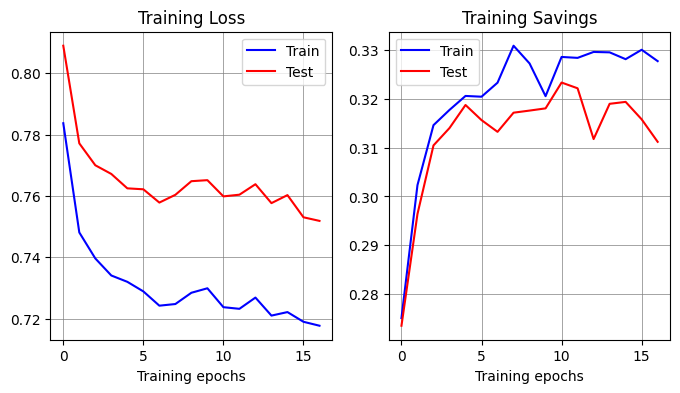

In [14]:
coste_final_tr = []
saving_final_tr = []
acc_final_step_tr = []
coste_final_ts = []
saving_final_ts = []
acc_final_step_ts = []

init_time = time.time()
for ii_run in range(number_of_runs):

    print(f"[INFO]: Run = {ii_run + 1} / {number_of_runs}")

    ## MODEL ##
    model_wr_cmlp = None
    model_wr_cmlp = WR_CMLP_model(input_size=len(tensor_x_tr[1,:]), hidden_size=n_neurons)
    ###########

    ## Optimizer ##
    RMSprop_optim = torch.optim.RMSprop(model_wr_cmlp.parameters(), lr=lr, momentum=momentum, centered=centered)
    ###############

    ## Loss function ##
    loss = model_wr_cmlp.weighted_cost_norm_mse_loss
    ###################

    ## Training ##
    print(f"[INFO]: Training")
    results_training = model_wr_cmlp.train_discriminator(optimizer=RMSprop_optim,
                                                         criterion=loss,
                                                         num_epochs=epochs,
                                                         batch_size=batch_size,
                                                         inputs_train=tensor_x_tr,
                                                         labels_train=tensor_y_tr,
                                                         inputs_test=tensor_x_ts,
                                                         labels_test=tensor_y_ts,
                                                         cr01=tensor_Cr01,
                                                         cr10=tensor_Cr10,
                                                         cr00=tensor_Cr00,
                                                         cr11=tensor_Cr11,
                                                         cs01=tensor_Cs01,
                                                         cs10=tensor_Cs10,
                                                         cs00=tensor_Cs00,
                                                         cs11=tensor_Cs11,
                                                         ir_objetive=ir_total_tr/rebalance,
                                                         ir_original=ir_total_tr,
                                                         figure=plot_training,
                                                         metrics=True,
                                                         )

    loss_tr_onFly = results_training['loss_train']
    loss_ts__onFly = results_training['loss_test']
    saving_tr_onFly = results_training['saving_train']
    saving_ts_onFly = results_training['saving_test']
    ##############

    ######## Metrics ########
    results_tr = model_wr_cmlp.metrics(x_input=tensor_x_tr,
                                       target_class=tensor_y_tr,
                                       c01=tensor_Cr01,
                                       c10=tensor_Cr10,
                                       rebalance=rebalance)
    coste_final_tr.append(results_tr['coste_final'])
    saving_final_tr.append(results_tr['saving_final'])
    acc_final_step_tr.append(results_tr['accuracy'])

    results_ts = model_wr_cmlp.metrics(x_input=tensor_x_ts,
                                       target_class=tensor_y_ts,
                                       c01=tensor_Cs01,
                                       c10=tensor_Cs10,
                                       rebalance=rebalance)
    coste_final_ts.append(results_ts['coste_final'])
    saving_final_ts.append(results_ts['saving_final'])
    acc_final_step_ts.append(results_ts['accuracy'])
    #########################


end_time = time.time()
print(f'[INFO]: Total execution time -> {numpy.round((end_time-init_time)/60, 2)} mins', )

print()
print('___________________________________________________________')
print('Final results Train')
print(f'\t accuracy     -> {numpy.round(numpy.mean(acc_final_step_tr), 2)} std {numpy.round(numpy.std(acc_final_step_tr), 2)}')
print(f'\t Savings      -> {numpy.round(numpy.mean(saving_final_tr) * 100, 2)} std {numpy.round(numpy.std(saving_final_tr) * 100, 2)}')
print(f'\t Cost         -> {numpy.round(numpy.mean(coste_final_tr), 2)} std {numpy.round(numpy.std(coste_final_tr), 2)}')

print()
print()
print('Final results Test')
print(f'\t accuracy     -> {numpy.round(numpy.mean(acc_final_step_ts), 2)} std {numpy.round(numpy.std(acc_final_step_ts), 2)}')
print(f'\t Savings      -> {numpy.round(numpy.mean(saving_final_ts) * 100, 2)} std {numpy.round(numpy.std(saving_final_ts) * 100, 2)}')
print(f'\t Cost         -> {numpy.round(numpy.mean(coste_final_ts), 2)} std {numpy.round(numpy.std(coste_final_ts), 2)}')
print('___________________________________________________________')

print(f'[INFO]: End', )

#### Section 3.1 Compute model output with CMLP Method

In [15]:
output_train = model_wr_cmlp.forward(tensor_x_tr.float()) # Outputs of the NN model, but not deccions
output_train_numpy = output_train.detach().flatten().numpy()
output_train_numpy

array([ 0.6128361 ,  0.7739282 ,  0.31824738, ...,  0.25818166,
        0.9340976 , -0.05612026], dtype=float32)

#### Section 3.1 Predict the class with CMLP Method

In [16]:
ir_objetive = ir_train / rebalance
y_pred_train = model_wr_cmlp.predict_class(output_train, q_neutral=ir_train/ir_objetive) # Costs Decissions in [-1, +1]
y_pred_train_numpy = y_pred_train.detach().flatten().numpy()
y_pred_train_numpy

array([ 1.,  1.,  1., ..., -1.,  1., -1.])